### Set up imports

In [1]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from torch.nn import L1Loss
from tqdm import tqdm

from generative.inferers import LatentDiffusionInferer
from generative.losses import PatchAdversarialLoss, PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler

print_config()

/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.3.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.24.0
scipy version: 1.14.0
Pillow version: 10.3.0
Tensorboard version: 2.17.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.18.1+cu121
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.8
pandas version: 2.2.2
einops version: 0.8.0
transformers version: 4.40.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installin

In [2]:
# for reproducibility purposes set a seed
set_determinism(42)

In [3]:
from src.dataset import load_dataset, DatasetConfig

In [4]:
ds_config = DatasetConfig(
    path = "/ravana/d3d_work/micorl/data/ct_images_prostate_32fixed",
    image_size=128
)

In [5]:
# ds = load_dataset("/ravana/d3d_work/micorl/data/ct_images_prostate_32fixed/")
ds = load_dataset(ds_config)

Caching to disk


In [151]:
batch_size = 1
channel = 0  # 0 = Flair

In [152]:
train_loader = DataLoader(
            ds,
            batch_size=batch_size,
            num_workers=8,
            shuffle=True,
            pin_memory=torch.cuda.is_available(),
        )

### Visualise examples from the training set

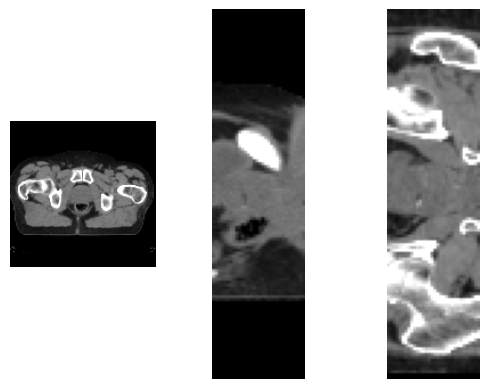

In [87]:
# Plot axial, coronal and sagittal slices of a training sample
check_data = first(train_loader)
idx = 0

img = check_data[idx, 0]
fig, axs = plt.subplots(nrows=1, ncols=3)
for ax in axs:
    ax.axis("off")
ax = axs[0]
ax.imshow(img[..., img.shape[2] // 2], cmap="gray")
ax = axs[1]
ax.imshow(img[:, img.shape[1] // 2, ...], cmap="gray")
ax = axs[2]
ax.imshow(img[img.shape[0] // 2, ...], cmap="gray")
# plt.savefig("training_examples.png")

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

Using cuda:0


In [10]:
# from src.models.monai_autoencoder import GAN

from src.models.transformers_ct_reconstruction.vqgan.model import VQVAE
# from src.models.medical_diffusion.vq_gan_3d.model.vqgan import VQGAN

In [30]:
vqvae = VQVAE.load_from_checkpoint("../models/german_vqvae/checkpoints/last-v10.ckpt", map_location=device).eval()
# vqgan = VQVAE.load_from_checkpoint("../models/meta_vqgan/checkpoints/meta_vqgan-v5.ckpt", map_location=device)

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gormat/Documents/ct-images-augmentation/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
# vqgan = vqgan.to(device)

In [15]:
check_data.shape

torch.Size([1, 1, 128, 128, 32])

In [17]:
from src.utils import dicom_batch_to_video_batch, video_batch_to_dicom_batch

In [88]:
x = dicom_batch_to_video_batch(check_data).to(device)

In [89]:
check_data.shape

torch.Size([1, 1, 128, 128, 32])

In [90]:
x.shape

torch.Size([1, 1, 32, 128, 128])

In [105]:
with torch.no_grad():
    with autocast(enabled=True):
        # z = autoencoder.encode_stage_2_inputs(check_data.to(device))
        # frames, frames_rec, _, _ = vqgan.step(x.as_tensor().to(device), 2, log_image=True)
        # z, vq_output, x_recon = vqgan.forward(x.as_tensor().to(device))
        # out, out_hor, emb_loss = vqvae.forward(x.as_tensor().to(device))
        z = vqvae.encode(x.as_tensor().to(device))

        # log = vqgan.log_videos(x.as_tensor().to("cuda:0"))


We define the inferer using the scale factor:

In [107]:
x.shape

torch.Size([1, 1, 32, 128, 128])

In [106]:
z.shape

torch.Size([1, 8, 4, 16, 16])

In [92]:
out_hor

[]

In [93]:
out.shape

torch.Size([1, 1, 32, 128, 128])

In [94]:
from src.utils import plot_dicom

In [95]:
x_recon = video_batch_to_dicom_batch(out)

In [96]:
x_recon.min()

tensor(-0.1027, device='cuda:0', dtype=torch.float16)

In [97]:
import torch

# Assuming x_recon is a tensor
# Example: x_recon = torch.randn((batch_size, channels, height, width))

# Find the minimum and maximum values in x_recon
min_val = torch.min(x_recon)
max_val = torch.max(x_recon)

# Rescale x_recon to the range [0, 1]
x_recon_rescaled = (x_recon - min_val) / (max_val - min_val)

# Now you can use the rescaled x_recon
# reconstruction = video_batch_to_dicom_batch(x_recon_rescaled)

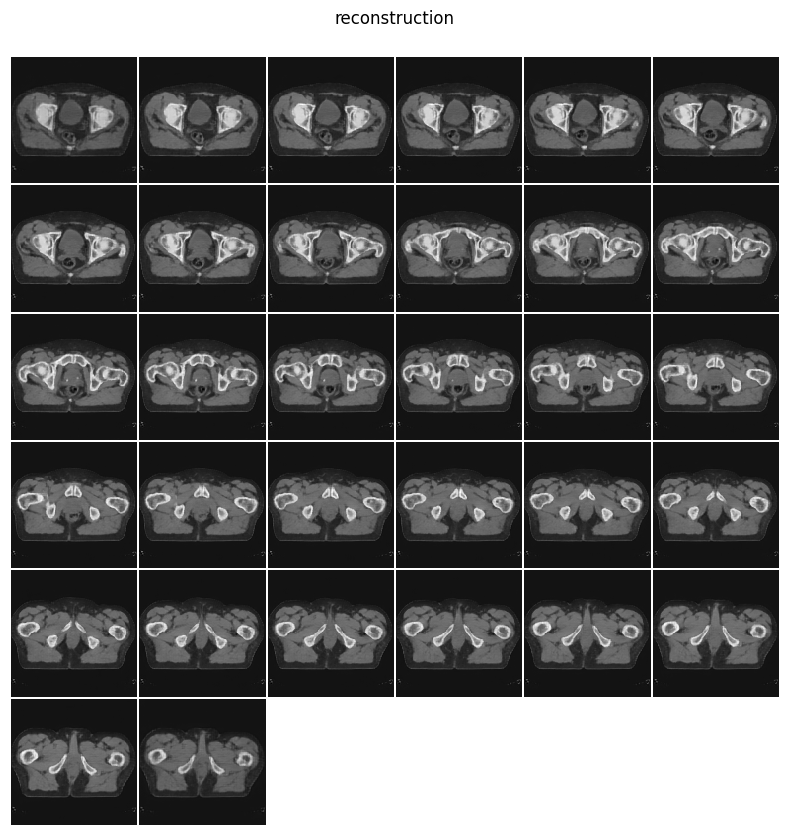

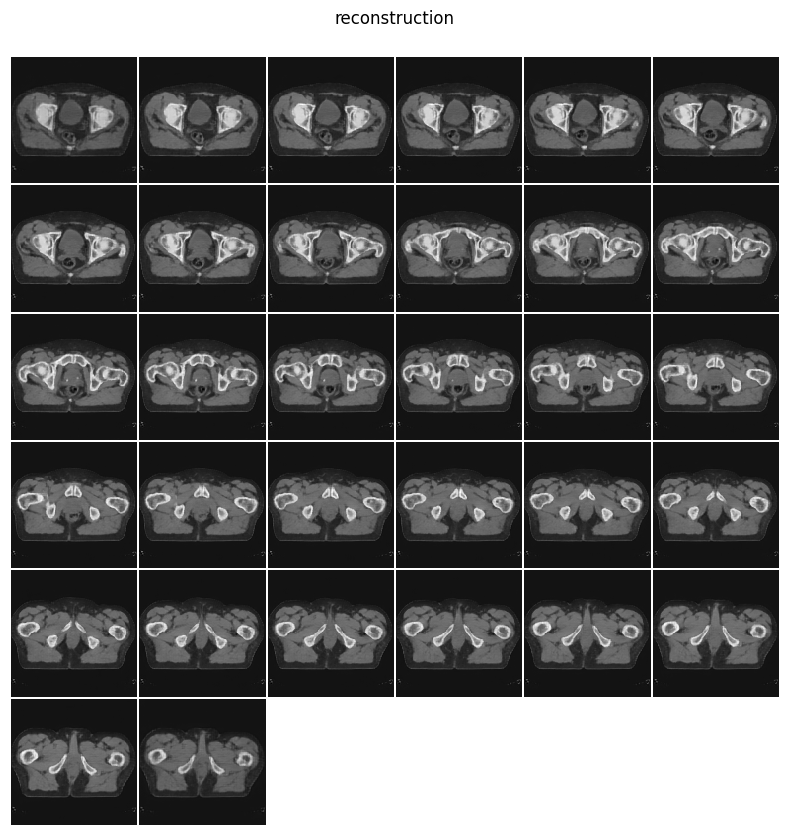

In [102]:
from tabnanny import check

from numpy import rec


# plot_dicom(reconstructions[0], "reconstruction")
# plot_dicom((x_recon_rescaled.cpu()-check_data).abs(), "reconstruction")
plot_dicom(x_recon_rescaled.cpu(), "reconstruction")
# plt.savefig("../reports/meta_autoenc_reconstruction_full.png")

In [49]:
from src.utils import make_comparison

In [70]:
comp = make_comparison(check_data, x_recon.to("cpu"))

In [71]:
from torchvision.utils import make_grid

In [72]:
make_grid(comp).permute(1, 2, 0).shape

torch.Size([1562, 1042, 3])

In [81]:
comp2 = make_grid(comp, nrow=32, normalize=True).permute(1, 2, 0)

In [82]:
from PIL import Image

In [83]:
comp2.numpy().shape

(392, 4162, 3)

In [75]:
im = Image.fromarray(comp2.numpy())
im.save("../reports/german_vqvae_reconstruction_full.png")

TypeError: Cannot handle this data type: (1, 1, 4162), <f4

In [79]:
import matplotlib

In [84]:
matplotlib.image.imsave("../reports/german_vqvae_reconstruction_full.png", comp2.numpy())

In [104]:
vqvae.global_step

0

In [158]:
from src.utils import calculate_common_metrics



In [156]:
device

device(type='cuda', index=0)

In [159]:
metrics = {
    "L2": 0,
    "L1": 0,
    "ssim": 0,
    "lpips": 0,
}
for batch in train_loader:
    with torch.no_grad():
        x = dicom_batch_to_video_batch(batch).to(device)
        out, out_hor, emb_loss = vqvae.forward(x.as_tensor().to(device))
        x_recon = video_batch_to_dicom_batch(out)
        current_metrics = calculate_common_metrics(batch.to(device), x_recon.to(device))
        for k, v in current_metrics.items():
            metrics[k] += v

for k, v in metrics.items():
    metrics[k] = v / len(train_loader)

Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Setting up [baseline] perceptual loss:

In [160]:
metrics

{'L2': metatensor(0.0023, device='cuda:0'),
 'L1': metatensor(0.0212, device='cuda:0'),
 'ssim': metatensor(0.9399, device='cuda:0'),
 'lpips': metatensor([[[[[1.3820]]]]], device='cuda:0')}

In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
